# Train SVC (Support Vector Classifier) model on kss events

Train and evaluate against training set

This is to verify the algorithms are working.
Validation is done manually and will come later.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
from display import Disp
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline

from audio import Audio
from kss_df import KssDf
from transformers import SlidingWindow

font_path = '/Users/dev/Fonts/Noto_Sans_KR/NotoSansKR-Regular.otf'
k_prop = mfm.FontProperties(fname=font_path)
plt.style.use('dark_background')

# Display handler with some nice helpers
disp = Disp(display)
# Uncomment to see the source code
# disp.code('display.py', label='display.py ')


# disp examples
# disp(IPython.display.Audio('./data/korean-single-speaker/kss/1/1_0000.wav'))
# disp_file_source('marker_df.py', label='marker_df')
# disp_audio_file('./data/korean-single-speaker/kss/1/1_0000.wav', label='1_0000.wav')

## Load Training Data

In [2]:
from filename_versioner import FilenameVersioner

import joblib
tng_data_dir = './data/model'

fv_xy = FilenameVersioner(('xy_trn_rms', 'joblib'), base_dir=tng_data_dir)
fv_shared_params = FilenameVersioner(('shared_params', 'joblib'), base_dir=tng_data_dir)

xy_file_base, xy_vsn = fv_xy.get_base_and_version()
shared_params_file_base, shared_params_vsn = fv_shared_params.get_base_and_version()
training_version = f'xy{xy_vsn}p{shared_params_vsn}'

xy_file = f'{fv_xy.base_dir}/{xy_file_base}'
disp.obj(xy_file, 'X file name')
shared_params_file = f'{fv_shared_params.base_dir}/{shared_params_file_base}'
disp.obj(shared_params_file, 'y file name')

_, y_train, mfcc = joblib.load(xy_file)



disp.obj(mfcc, label='mfcc')
disp.obj(y_train, label='y')
disp.obj((mfcc.shape, np.mean(mfcc)), label='mfcc shape, mean' )
disp.obj((y_train.shape, np.mean(y_train)), label='y shape, mean')

X file name

'./data/model/xy_trn_rms.1.joblib'

y file name

'./data/model/shared_params.0.joblib'

mfcc

array([[-7.1262109e+02, -7.1262109e+02, -7.1262109e+02, ...,
        -7.3174597e+02, -7.3630151e+02, -7.5105756e+02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         2.6883358e+01,  2.3628345e+01,  8.6897449e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         6.9355450e+00,  7.7811923e+00,  3.2005405e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         3.0394402e+00, -2.1301982e+00, -2.8990357e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -3.1133916e+00, -3.8317370e+00, -1.1933264e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -6.2087722e+00, -4.4717379e+00, -2.0541152e-01]], dtype=float32)

y

array([False, False, False, ..., False, False, False])

mfcc shape, mean

((8, 7976), -74.3729)

y shape, mean

((7976,), 0.8134403209628887)

## Train Model and Save: ADA

### Individual MFCC Models

Train a model on each mfcc individually. Later we will combine them into an ensemble



#### Wrap Ensemble in pipeline
We wrap the model in a pipeline as we need to do some transformations (creating windowed features for X)
and GridSearch for best estimators

In [3]:
from pipewrap import PipeWrap


sliding_window = SlidingWindow()
disp.obj(sliding_window, label='SlidingWindow')


# Models and processing
model_id = 'ada'
model = AdaBoostClassifier()
# Using sklearn pipeline creates a problem with comparing saved model vs current model since the model instance is
# returned with `pipe.get_params`, rather than the model parameters. I need to figure out a way to get around that
# in order to prevent unnecessary model updates.
# from transformers import SlidingWindow
steps = [('sw', sliding_window), (model_id, model)]
pw = PipeWrap(steps)

SlidingWindow

SlidingWindow()

In [4]:
from sklearn.ensemble import VotingClassifier


In [5]:
print(mfcc.shape)
print(y_train.shape)

(8, 7976)
(7976,)


In [6]:
from sklearn.model_selection import GridSearchCV

p = {
    'sw__window': [32, 64, 128, 256, 512, 1024],
    'sw__offset_percent': [0.5, 0.7, 0.75, 0.8, 0.85, 0.9],
    'ada__n_estimators': [10, 20],
    'ada__learning_rate': [1]
}

search = GridSearchCV(pw.pipe, p, n_jobs=-1, scoring='f1', verbose=4)

best_params = []
ests = []
for i, x_m in enumerate(mfcc):
    print(f'fitting run {i}')
    search.fit(x_m, y_train)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    best_params.append(search.best_params_)
    ests.append(search.best_estimator_)
# x_m1 = mfcc[1]

print('done')
print(best_params)

# search.fit(x_m1, y_train)
# print("Best parameter (CV score=%0.3f):" % search.best_score_)
# print(search.best_params_)
#
# # pw.pipe.fit(X_train, y_train)
# # Not sure if this will work
# pw.pipe = search.best_estimator_
# # pw.pipe.fit(X_train, y_train)




fitting run 0
Fitting 5 folds for each of 72 candidates, totalling 360 fits


SlidingWindow[INFO]: np sliding window shape: (9408, 1024)


Best parameter (CV score=0.954):
{'ada__learning_rate': 1, 'ada__n_estimators': 20, 'sw__offset_percent': 0.7, 'sw__window': 1024}
fitting run 1
Fitting 5 folds for each of 72 candidates, totalling 360 fits


SlidingWindow[INFO]: np sliding window shape: (9818, 1024)


Best parameter (CV score=0.894):
{'ada__learning_rate': 1, 'ada__n_estimators': 20, 'sw__offset_percent': 0.9, 'sw__window': 1024}
fitting run 2
Fitting 5 folds for each of 72 candidates, totalling 360 fits


SlidingWindow[INFO]: np sliding window shape: (8090, 64)


Best parameter (CV score=0.897):
{'ada__learning_rate': 1, 'ada__n_estimators': 10, 'sw__offset_percent': 0.9, 'sw__window': 64}
fitting run 3
Fitting 5 folds for each of 72 candidates, totalling 360 fits


SlidingWindow[INFO]: np sliding window shape: (8334, 256)


Best parameter (CV score=0.921):
{'ada__learning_rate': 1, 'ada__n_estimators': 20, 'sw__offset_percent': 0.7, 'sw__window': 256}
fitting run 4
Fitting 5 folds for each of 72 candidates, totalling 360 fits


SlidingWindow[INFO]: np sliding window shape: (8040, 64)


Best parameter (CV score=0.898):
{'ada__learning_rate': 1, 'ada__n_estimators': 20, 'sw__offset_percent': 0.5, 'sw__window': 64}
fitting run 5
Fitting 5 folds for each of 72 candidates, totalling 360 fits


SlidingWindow[INFO]: np sliding window shape: (8334, 256)


Best parameter (CV score=0.907):
{'ada__learning_rate': 1, 'ada__n_estimators': 20, 'sw__offset_percent': 0.7, 'sw__window': 256}
fitting run 6
Fitting 5 folds for each of 72 candidates, totalling 360 fits


SlidingWindow[INFO]: np sliding window shape: (8168, 128)


Best parameter (CV score=0.906):
{'ada__learning_rate': 1, 'ada__n_estimators': 20, 'sw__offset_percent': 0.75, 'sw__window': 128}
fitting run 7
Fitting 5 folds for each of 72 candidates, totalling 360 fits


SlidingWindow[INFO]: np sliding window shape: (8090, 64)


Best parameter (CV score=0.901):
{'ada__learning_rate': 1, 'ada__n_estimators': 10, 'sw__offset_percent': 0.9, 'sw__window': 64}
done
[{'ada__learning_rate': 1, 'ada__n_estimators': 20, 'sw__offset_percent': 0.7, 'sw__window': 1024}, {'ada__learning_rate': 1, 'ada__n_estimators': 20, 'sw__offset_percent': 0.9, 'sw__window': 1024}, {'ada__learning_rate': 1, 'ada__n_estimators': 10, 'sw__offset_percent': 0.9, 'sw__window': 64}, {'ada__learning_rate': 1, 'ada__n_estimators': 20, 'sw__offset_percent': 0.7, 'sw__window': 256}, {'ada__learning_rate': 1, 'ada__n_estimators': 20, 'sw__offset_percent': 0.5, 'sw__window': 64}, {'ada__learning_rate': 1, 'ada__n_estimators': 20, 'sw__offset_percent': 0.7, 'sw__window': 256}, {'ada__learning_rate': 1, 'ada__n_estimators': 20, 'sw__offset_percent': 0.75, 'sw__window': 128}, {'ada__learning_rate': 1, 'ada__n_estimators': 10, 'sw__offset_percent': 0.9, 'sw__window': 64}]


In [157]:
# Set up the model for saving
tng_data_dir = './data/model'
mfcc_model_id = f'{model_id}-mfcc-{len(ests)}'
model_file = f'{mfcc_model_id}.{training_version}'
fv = FilenameVersioner((model_file, 'joblib'), base_dir=tng_data_dir )

saved_model_path = fv.get_latest_path()
print(saved_model_path)

# TODO: Need a way to handle collections
saved_wrap = joblib.load(saved_model_path) if saved_model_path else None

# Save the pipeline so we can modify it later without changing this code
if saved_wrap is None or pw.params != saved_wrap.params:
    print('Detected new trained model')
    versioned_model_file = fv.increment_version()
    print(f'saving model as {versioned_model_file}')
    joblib.dump(ests, versioned_model_file)
    saved_wrap = joblib.load(fv.get_latest_path())
else:
    print('No changes detected')


./data/model/ada-mfcc-8.xy1p0.1.joblib


AttributeError: 'list' object has no attribute 'params'

## Evaluate Training

Evaluate the training data by seeing if our trained model will predict close to the data it was trained on.

Validation will come later

This is just to make sure our Model trained correctly. It might have overfit, but we don't care yet.

In [172]:
# Custom Predictor for mfccs, for now just does binary classification
class MfccPred:
    def __init__(self, ests, weights=None):
        # TODO: Move to fit?
        self.ests = ests
        self.weights = weights

    @staticmethod
    def pred_threshold(pred_vals, thresh=0.0):
        return np.where(pred_vals > thresh, True, False)

    def predict_numeric(self, x_mfcc):
        # TODO move weight calc to fit
        if self.weights is None:
            self.weights = np.ones(len(x_mfcc))

        assert len(x_mfcc) <= len(self.ests), f'{len(x_mfcc)} mfcc channels provided but there are only {len(self.ests)} estimators'
        # Convert from T/F to +1/-1, then multipy by weights
        y_interim_preds = [ (2*est.predict(x_mfcc[i])-1)*self.weights[i] for i, est in enumerate(self.ests)]
        return np.sum(y_interim_preds, axis=0)

    def predict(self, x_mfcc):
        return self.pred_threshold(self.predict_numeric(x_mfcc), thresh=0.0)

weight_options = [
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [2.0, 1.75, 1.5, 1.25, 1.0, 0.75, 0.5, 0.25],
    [5.0, 4.0, 0, 0, 0, 0 ,0, 0],
    [5.0, 2.5, 1.25, 0.75, 0.33, 0.17, 0.08, 0.05]
]
mfcc_pred = MfccPred(ests, weights=weight_options[3])


In [173]:
# TODO: Move these into a class
def pred_threshold(pred_vals, thresh=0.5):
    return np.where(pred_vals > thresh, True, False)

y_train_pred_num = mfcc_pred.predict_numeric(mfcc)
y_train_pred = mfcc_pred.predict(mfcc)

In [174]:
shared_params = joblib.load(fv_shared_params.get_latest_path())
# remove kss_ids from params just to keep things a bit cleaner
kss_ids = shared_params['kss']['trn_ids']
print(kss_ids)
audio_params = shared_params['audio']
# iterate over each kss_id, find the audio file, load it and return it's squeezed rms
x_rms = np.concatenate([Audio(KssDf(id).audio_path, **audio_params).rms.squeeze() for id in kss_ids])

sw_mean_offset = sliding_window.window-sliding_window.offset
sw_offset = 0

def align(y, offset):
    return np.pad(y, (offset, 0), 'minimum')

def delta(y1, y2, y1_offset, y2_offset):
    min_len = min(len(y1), len(y2))
    return np.logical_xor(align(y1, y1_offset)[0:min_len], align(y2, y2_offset)[0:min_len])

def speech_base_delta(y, offset):
    return delta(y, y_train, offset, 0)


/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Audio[INFO]: a.to_rms size: 2431, reduction factor 2430.0
Audio[WARNING]: Modifying input wav from size 175173 to 175232
Audio[INFO]: change in number of samples: 59 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 2739, reduction factor 2738.0
Audio[WARNING]: Modifying input wav from size 77573 to 77632
Audio[INFO]: change in number of samples: 59 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 1214, reduction factor 1213.0
Audio[WARNING]: Modifying input wav from size 101762 to 101824
Audio[INFO]: change in number of samples: 62 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 1592, reduction factor 1591.0


['1_0000', '1_0001', '1_0002', '1_0003']


In [162]:
# sw_pipe = Pipeline([('sw', pw.pipe.named_steps['sw'])])
# x_sw = sw_pipe.transform(X_train)

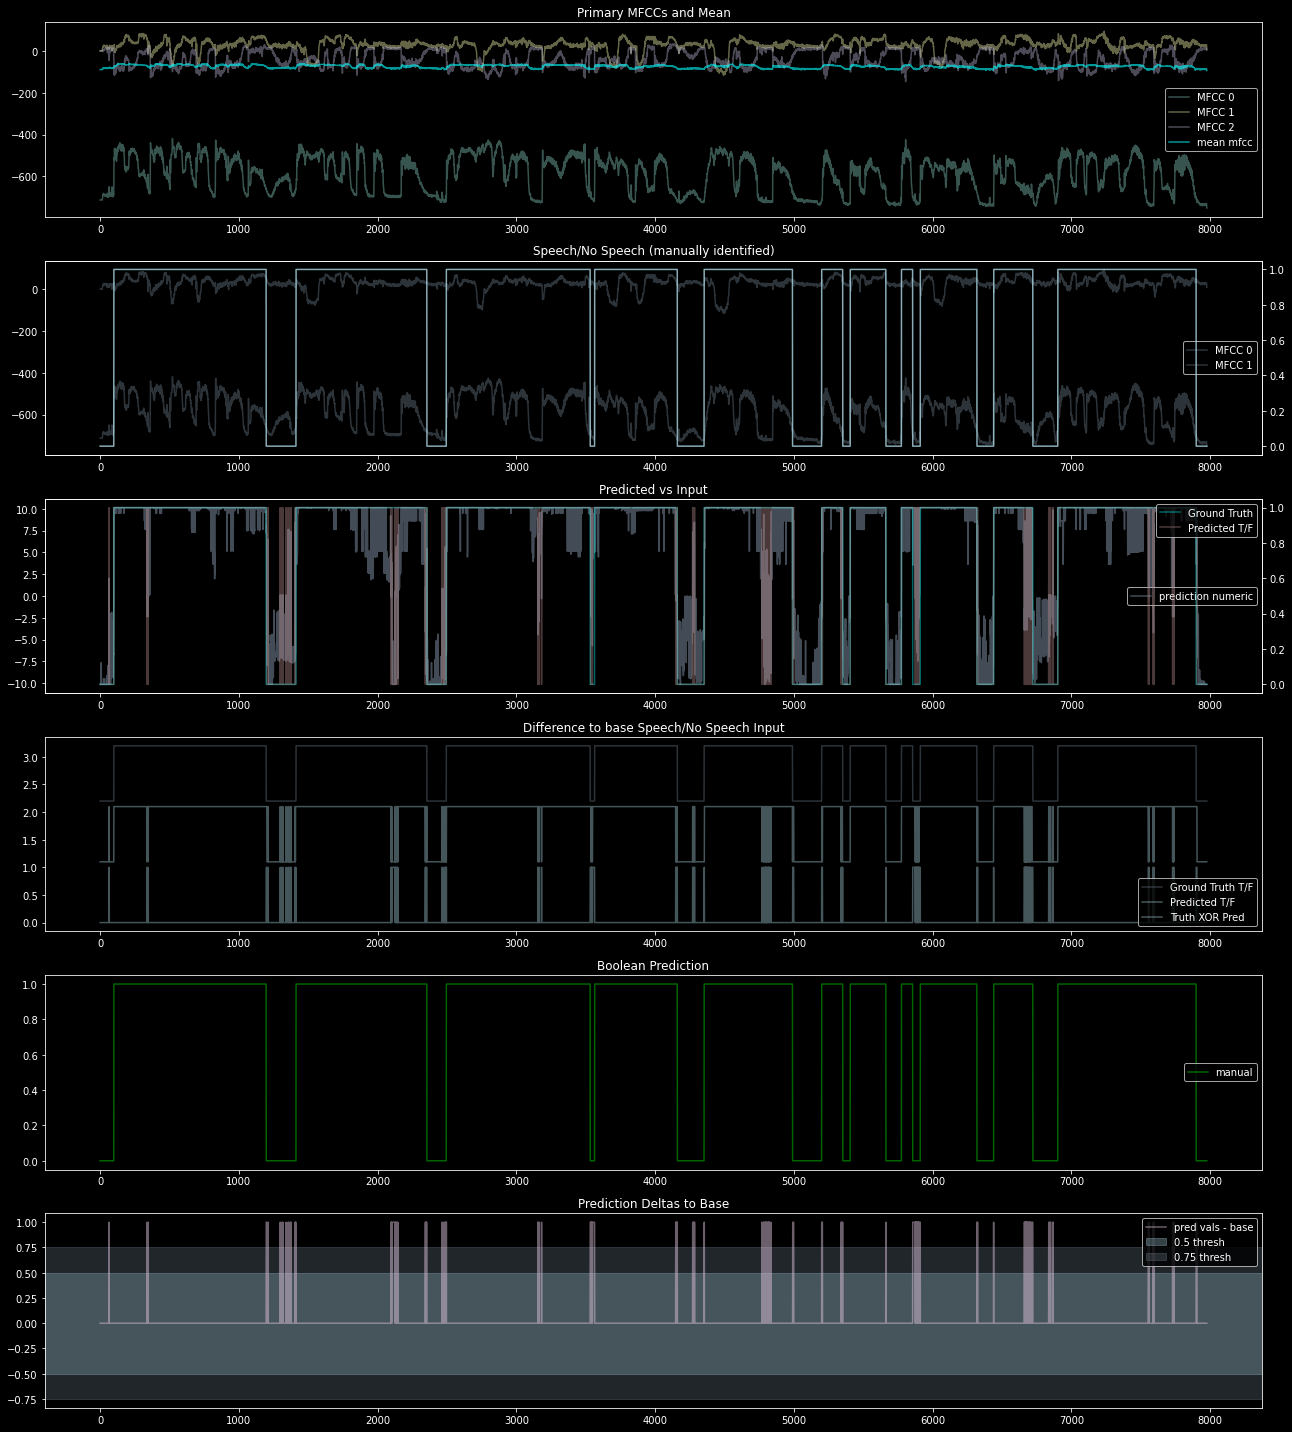

In [175]:
fig, axs  = plt.subplots(6, 1, figsize=(18,20))

axs[0].set_title(f'Primary MFCCs and Mean')
axs[0].plot(mfcc[0], alpha=0.4, label='MFCC 0')
axs[0].plot(mfcc[1], alpha=0.4, label='MFCC 1')
axs[0].plot(mfcc[2], alpha=0.4, label='MFCC 2')
axs[0].plot(np.mean(mfcc, axis=0), color='cyan', alpha=0.6, label='mean mfcc')
axs[0].legend(loc='center right')

axs[1].set_title(f'Speech/No Speech (manually identified)')
axs[1].plot(mfcc[0], color='slategray', alpha=0.4, label='MFCC 0')
axs[1].plot(mfcc[1], color='slategray', alpha=0.4, label='MFCC 1')
ax1a = axs[1].twinx()
ax1a.plot(y_train, color='lightblue', alpha=0.8, label='1: speech, 0: no speech')
axs[1].legend(loc='center right')

axs[2].set_title(f'Predicted vs Input')

# return self.pred_threshold(y_sum, thresh=-6.5)
axs[2].plot(y_train_pred_num, color='slategray', alpha=0.6, label='prediction numeric')
ax2a = axs[2].twinx()
ax2a.plot(y_train, color='cyan', alpha=0.4, label='Ground Truth')
ax2a.plot(y_train_pred, color='rosybrown', alpha=0.4, label='Predicted T/F')
axs[2].legend(loc='center right')
ax2a.legend(loc='upper right')

axs[3].set_title(f'Difference to base Speech/No Speech Input')
# axs[3].plot(x_rms, color='slategray', alpha=0.3, label='rms of audio')
# axs[3].plot(y_train.astype(int)-y_train.astype(int), color='yellow', alpha=0.8, label='base')
# axs[3].plot(speech_base_delta(y_train.astype(int), 0), color='lightblue', alpha=0.8, label="padded to align")
# axs[3].plot(speech_base_delta(y_train_pred, 0), color='thistle', alpha=0.5, label='pred delta')

axs[3].plot(y_train+2.2, color='slategray', alpha=0.4, label='Ground Truth T/F')
axs[3].plot(y_train_pred+1.1, color='lightblue', alpha=0.4, label='Predicted T/F')
axs[3].plot(np.logical_xor(y_train, y_train_pred), color='lightblue', alpha=0.4, label='Truth XOR Pred')
axs[3].legend(loc='lower right')

axs[4].set_title(f'Boolean Prediction')
# axs[4].plot(x_rms, color='slategray', alpha=0.3, label='rms of audio')
axs[4].plot(1*pred_threshold(y_train, 0.5), color='lime', alpha=0.4, label='manual')
axs[4].legend(loc='center right')

axs[5].set_title(f'Prediction Deltas to Base')
axs[5].plot(speech_base_delta(y_train_pred, 0), color='thistle', alpha=0.5, label='pred vals - base')
axs[5].axhspan(-0.5, 0.5, color='lightblue', alpha=0.3, label='0.5 thresh'),
axs[5].axhspan(-0.75, 0.75, color='slategray', alpha=0.3, label='0.75 thresh')
axs[5].legend(loc='upper right')

plt.tight_layout()
plt.show()

